# Свёрточная нейронная сеть (Convolutional Neural Network)

### Что такое свёрточный слой?

Применяем к изображению локальные преобразования, как, к примеру, на этой схеме

![convolution](https://colah.github.io/posts/2014-07-Understanding-Convolutions/img/RiverTrain-ImageConvDiagram.png)

Many important image transformations are convolutions where you convolve the image function with a very small, local function called a “kernel.”

Можно взять квадратик три на три, усреднить значения пикселей в нём, и записать в "центральную" ячейку этого квадратика в новой картинке. 

**Вопрос: что получим?**

А если вот так -- то получим edge detection. Почему? ![1-1](https://colah.github.io/posts/2014-07-Understanding-Convolutions/img/Gimp-Edge.png)

Есть куча таких фильтров -- можно открыть документацию GIMP и почитать, как они какими-то вот такими простыми способами преобразовывают изображения нам на радость.


В общем, есть подозрение, что локальную структуру можно как-то использовать для того, чтобы понимать, как устроено изображение, и что на нём показано. В частности, можно **ОБУЧАТЬ эти маленькие матрицы**.


In [2]:
import torch
import torch.nn
from torch.nn import Conv2d

![sdfs](https://d2l.ai/_images/conv-pad.svg)

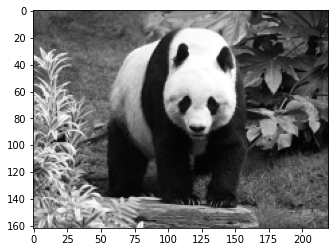

In [2]:
import skimage
import skimage.io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.transform import rescale


image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/440px-Grosser_Panda.JPG"
original = skimage.io.imread(image_url)

grayscale = rescale(rgb2gray(original), 0.5)

plt.imshow(grayscale, cmap=plt.cm.gray)

In [3]:
grayscale.shape

(162, 220)

In [4]:
img = torch.tensor(grayscale).unsqueeze(0).unsqueeze(1)
img.shape

torch.Size([1, 1, 162, 220])

In [5]:
conv = Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3)).double()

list(conv.parameters())

[Parameter containing:
 tensor([[[[ 0.0247, -0.0053, -0.1266],
           [ 0.1553,  0.0287, -0.0608],
           [ 0.2322,  0.0283, -0.2352]]]], dtype=torch.float64,
        requires_grad=True), Parameter containing:
 tensor([-0.1981], dtype=torch.float64, requires_grad=True)]

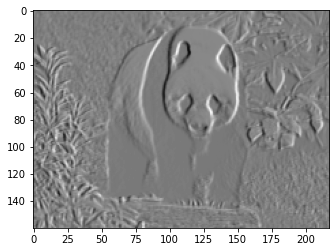

In [6]:
plt.imshow(conv(img).detach().numpy()[0, 0], cmap=plt.cm.gray)

Давайте всё размоем!

**Как это сделать с помощью Conv2d?**

In [7]:
conv.weight.data = torch.ones_like(conv.weight.data) / torch.ones_like(conv.weight.data).sum()
conv.bias.data = torch.zeros_like(conv.bias.data)
conv.weight.data

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]], dtype=torch.float64)

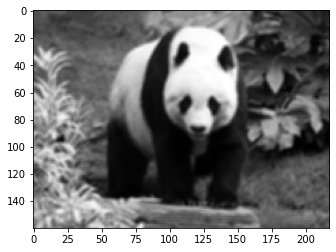

In [8]:
plt.imshow(conv(img).detach().numpy()[0, 0], cmap=plt.cm.gray)

In [9]:
conv.weight.data = torch.tensor([[[
  [1, 0, -1],
  [2, 0, -2],
  [1, 0, -1]
]]]).double()


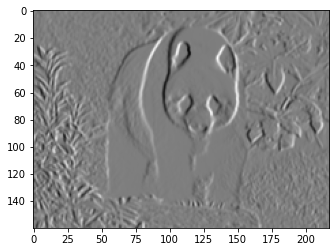

In [10]:
plt.imshow(conv(img).detach().numpy()[0, 0], cmap=plt.cm.gray)

### Conv2d: документация

In the simplest case, the output value of the layer with input size
$(N, C_{\text{in}}, H, W)$ and output $(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})$    can be precisely described as:
    
$$\text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) + \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)$$

$\star$ is the valid 2D `cross-correlation`_ operator,$N$ is a batch size, $C$ denotes a number of channels, $H$ is a height of input planes in pixels, and $W$ is width in pixels.

---

Формула требует некоторых усилий от читателя. Для начала -- мы смотрим результат для фиксированного батча и для фиксированного выхода $C_{out_j}$. То есть по сути $out(...)$ -- это один из каналов итога размеров $W_{out}$ на $H_{out}$.

Для каждого канала на выходе применяем поэлементное умножение матриц на входы + добавляем bias.

kernel_size, stride, padding, dilation -- можно задать интом, можно парой; первое для высоты, второе для ширины.

Хорошая визуализация dilation и прочих трюков [здесь](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md).

## ReLU

Раньше мы пользовались tanh в качестве функции активации:
![1-1](https://qph.cf2.quoracdn.net/main-qimg-f1baf29cfdb09202b18e2179f4f41bfc)



<img width=500 src="https://pytorch.org/docs/stable/_images/ReLU.png"/>

In [11]:
relu = torch.nn.ReLU()
relu

ReLU()

## Adam

https://pytorch.org/docs/stable/generated/torch.optim.Adam.html


# CIFAR10

*The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.*

*The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.*

![**Текст, выделенный полужирным шрифтом**](https://pytorch.org/tutorials/_images/cifar10.png)

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


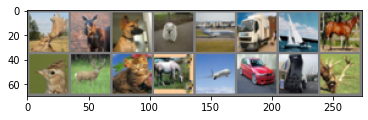

deer  deer  dog   dog   plane truck ship  horse bird  deer  cat   horse plane car   truck deer 


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


### Lekun, Bottou, Bengio, Haffner (1998)

<div align="center">
    <p> </p>
    <img src="https://production-media.paperswithcode.com/methods/LeNet_Original_Image_48T74Lc.jpg" alt="LeNet" width=1000 />
</div>


In [15]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.003)

In [17]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [18]:
writer = SummaryWriter(log_dir="logs")

In [19]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.876
[1,  2000] loss: 0.767
[1,  3000] loss: 0.728
[2,  1000] loss: 0.690
[2,  2000] loss: 0.683
[2,  3000] loss: 0.672
[3,  1000] loss: 0.635
[3,  2000] loss: 0.634
[3,  3000] loss: 0.642
Finished Training


In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [22]:
net = Net().to(device)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.003)

In [47]:
def train_epoch(epoch, trainloader, net, optimizer, criterion):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

In [38]:
 
for epoch in range(3):  # loop over the dataset multiple times
    train_epoch(epoch, trainloader, net, optimizer, criterion)

print('Finished Training')

[1,  1000] loss: 0.632
[1,  2000] loss: 0.646
[1,  3000] loss: 0.631
[2,  1000] loss: 0.610
[2,  2000] loss: 0.612
[2,  3000] loss: 0.614
[3,  1000] loss: 0.585
[3,  2000] loss: 0.596
[3,  3000] loss: 0.598
Finished Training


## Визуализация результатов


In [25]:
inputs, _ = next(iter(trainloader))
x_batch = inputs.to(device)

In [26]:
from matplotlib import gridspec

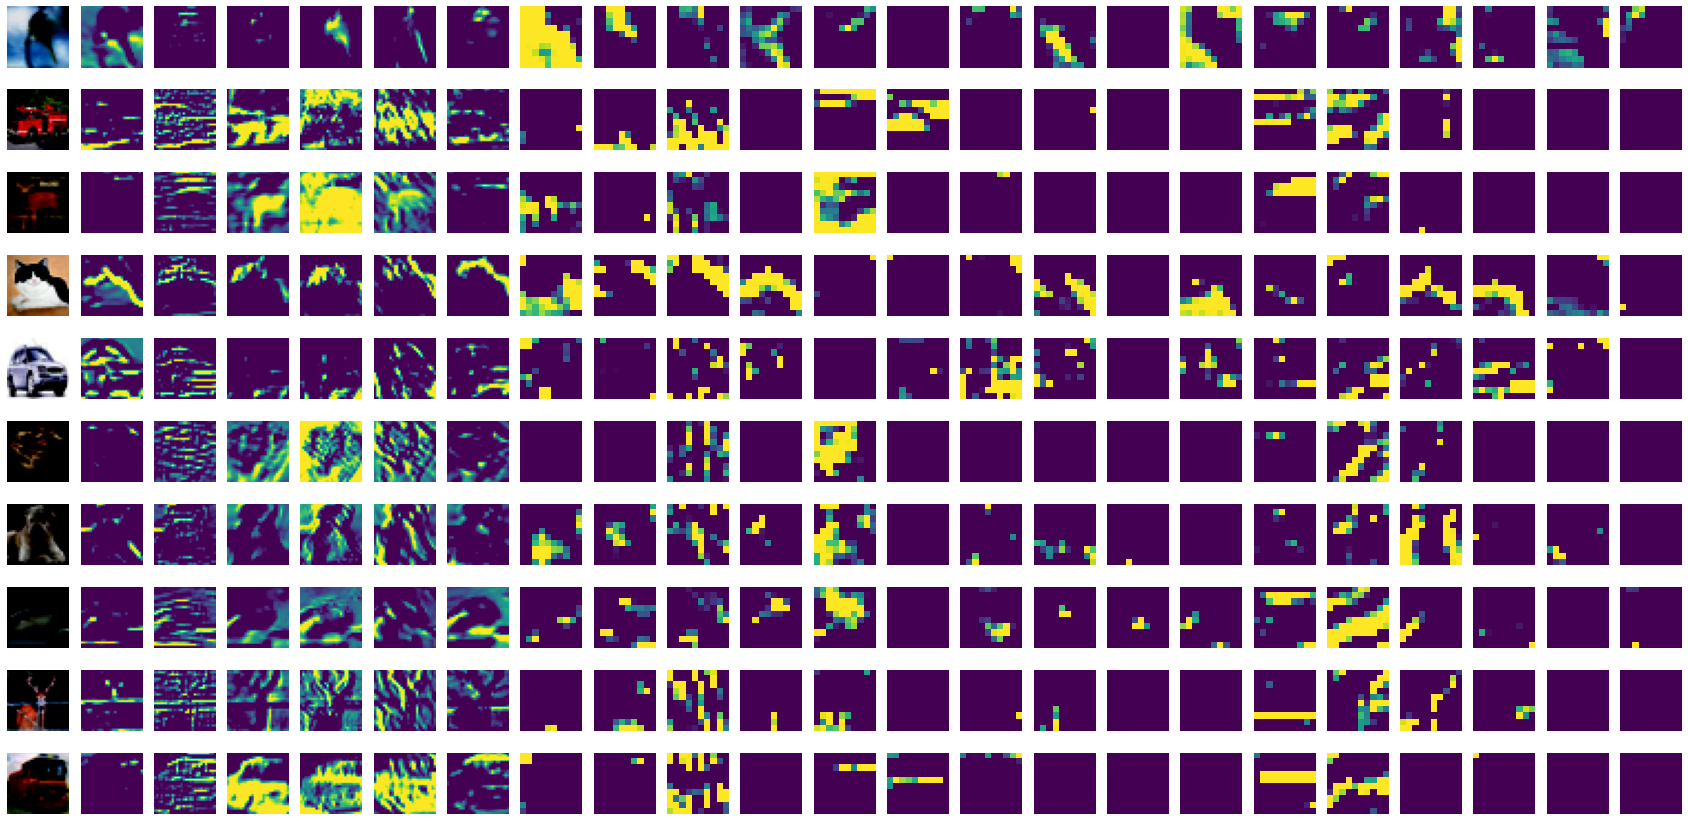

In [27]:
x = x_batch[:10]
y = F.relu(net.conv1(x))
z = F.relu(net.conv2(net.pool(y)))

fig = plt.figure(figsize=(30, 15))
gs = gridspec.GridSpec(10, 23)
ax = np.empty([10, 23], dtype=object)
for i in range(10):
    for j in range(23):
        ax[i][j] = fig.add_subplot(gs[i, j])
for i in range(len(x)):
    ax[i][0].imshow(np.clip(np.moveaxis(x.cpu().data[i].numpy(), 0, 2), 0, 1))
    ax[i][0].axis("off")
    for j in range(1, 7):
        ax[i][j].imshow(np.clip(y.cpu().data[i, j-1].numpy(), 0, 1))
        ax[i][j].axis("off")

    for j in range(7, 23):
        ax[i][j].imshow(np.clip(z.cpu().data[i, j-7].numpy(), 0, 1))
        ax[i][j].axis("off")

Tensorboard
Самый простой способ сравнить "успешность", да и вообще процесс обучения разных моделей, начальных настроек и методов обучения (в нашем случае оптимизаторов) -- это нарисовать графики, как меняются во времени, скажем, значения функций невязки (loss).

Tensorboard -- конфигурируемый инструмент, изначально разработанный для Tensorflow, который позволяет визуализировать и вообще отслеживать процесс обучения в реальном времени

AlexNet

In [40]:
class AlexNet(nn.Module):
    def __init__(self, ):
        num_classes=10
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

# Regularization



In [ ]:
l2_lambda = 0.01
l2_reg = torch.tensor(0.)

for param in net.parameters():
    l2_reg += torch.norm(param)

# loss += l2_lambda * l2_reg

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
l1_lambda = 0.001
l1_reg = torch.tensor(0.)

for param in net.parameters():
    l1_reg += torch.norm(param, 1)

# loss = loss + l1_lambda * l1_norm

# Dropout

https://medium.com/analytics-vidhya/understanding-regularization-with-pytorch-26a838d94058



In [4]:
x = torch.randn((1, 32))
d = torch.nn.Dropout()

In [5]:
d.train()	

print(d(x))
print(d(x))

tensor([[ 0.7735,  1.9236, -1.3194,  0.0000,  0.0000,  0.0000,  2.9777, -0.4971,
         -0.7240,  0.0000,  0.8878, -0.0000, -0.0000,  1.1823,  0.0000, -0.0000,
         -0.0000, -2.3809, -0.0000, -0.6907, -3.8434,  1.9701,  0.0000, -0.0000,
         -0.0000,  0.0000, -0.5863,  0.0000, -0.1560,  4.2735,  2.6882,  0.0000]])
tensor([[ 0.7735,  0.0000, -0.0000,  0.7378,  0.0000,  0.0000,  2.9777, -0.0000,
         -0.0000,  1.3306,  0.0000, -0.8775, -0.0000,  0.0000,  0.0000, -0.2241,
         -0.0000, -2.3809, -0.3538, -0.6907, -3.8434,  1.9701,  0.0000, -0.0000,
         -0.0000,  1.7072, -0.0000,  0.0000, -0.1560,  0.0000,  0.0000,  0.0000]])


In [6]:
d.eval()

print(d(x))
print(d(x))

tensor([[ 0.3867,  0.9618, -0.6597,  0.3689,  0.8875,  0.3203,  1.4888, -0.2486,
         -0.3620,  0.6653,  0.4439, -0.4388, -0.2254,  0.5911,  1.0308, -0.1120,
         -0.6317, -1.1905, -0.1769, -0.3454, -1.9217,  0.9850,  1.5625, -0.5451,
         -1.1808,  0.8536, -0.2931,  1.2867, -0.0780,  2.1368,  1.3441,  1.0104]])
tensor([[ 0.3867,  0.9618, -0.6597,  0.3689,  0.8875,  0.3203,  1.4888, -0.2486,
         -0.3620,  0.6653,  0.4439, -0.4388, -0.2254,  0.5911,  1.0308, -0.1120,
         -0.6317, -1.1905, -0.1769, -0.3454, -1.9217,  0.9850,  1.5625, -0.5451,
         -1.1808,  0.8536, -0.2931,  1.2867, -0.0780,  2.1368,  1.3441,  1.0104]])


In [48]:
net = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [49]:
net.train()	
for epoch in range(3):  # loop over the dataset multiple times
    train_epoch(epoch, trainloader, net, optimizer, criterion)

print('Finished Training')

[1,   500] loss: 0.513
[1,  1000] loss: 0.452
[1,  1500] loss: 0.424
[1,  2000] loss: 0.399
[1,  2500] loss: 0.384
[1,  3000] loss: 0.372
[2,   500] loss: 0.346
[2,  1000] loss: 0.343
[2,  1500] loss: 0.337
[2,  2000] loss: 0.328
[2,  2500] loss: 0.324
[2,  3000] loss: 0.321
[3,   500] loss: 0.305
[3,  1000] loss: 0.303
[3,  1500] loss: 0.299
[3,  2000] loss: 0.304
[3,  2500] loss: 0.298
[3,  3000] loss: 0.288
Finished Training


In [52]:
net.eval()
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 59 %


# VGG16
2014 год

https://arxiv.org/abs/1409.1556


*Most unique thing about VGG16 is that instead of having a large number of hyper-parameter **they focused on having convolution layers of 3x3 filter with a stride 1 and always used same padding and maxpool layer of 2x2 filter of stride 2**. It follows this arrangement of convolution and max pool layers consistently throughout the whole architecture. In the end it has 2 FC(fully connected layers) followed by a softmax for output. The 16 in VGG16 refers to it has 16 layers that have weights. This network is a pretty large network and it has about 138 million (approx) parameters.* 




![sdsd](https://neurohive.io/wp-content/uploads/2018/11/vgg16-neural-network.jpg)

https://neurohive.io/en/popular-networks/vgg16/

In [28]:
from torch import nn
import torch

In [29]:
import torchvision
from torchvision import transforms
from torchvision import models

`torchvision` мы уже трогали -- библиотека с инструментами, помогающими обучать модели компьютерного зрения на `pytorch`

VGG16 -- это настолько попса (т.е. важная базовая модель), что она есть в torchvision.models.

In [30]:
vgg16 = models.vgg16()

Для большей части картиночных моделей можно скачать веса "после обучения на [ImageNet](https://www.image-net.org/index.php)". 1000 классов, тьма картинок.


![example](https://www.researchgate.net/profile/Abhishek-Kumar-66/publication/321242021/figure/fig1/AS:643098833068033@1530338118382/Samples-from-ImageNet-classes-Easy-and-hard-samples-from-goldfish-artichoke-spacecraft.png)

# Упражнение (важное и полезное) 

1. Реализуйте оценку качесва модели на обучающей и тестовой выборке. Посторойте графики 

2. Обучайте сеть на CIFAR в течение одной эпохи на CPU. Потом попробуйте сделать то же самое на GPU.  Сравните затраченное время.

3. Выберите несколько разных оптимизаторов, исключая SGD https://pytorch.org/docs/stable/optim.html, обучите модель с помощью каждого из выбранных оптимизаторов, используя параметры по умолчанию. 

4. Попробуйте улучшить качесво модели AlexNet на CIFAR




Возможно, в какой-то момент гугл потребует освободить машину, которую вы используете для запуска ноутбука.

Чтобы снизить вероятность этого:

1. Перед запуском долгих вычислений перезапустите сессию (справа сверху, где ОЗУ и Диск). Если сессия запущена менее 8 часов тому назад, всё ОК. Сессии дольше 12 часов гугл не держит.

2. Не закрывайте вкладку, когда считаете. Распределяя вычислительные ресурсы, гугл даёт больший приоритет "активным" пользователям.

3. Если у вас есть на машине своя NVIDIA GPU, можно попробовать запустить colab как локальную сессию (тоже настраивается там, где "ОЗУ и Диск").

А если это всё-таки произойдёт -- то у вас должны быть сохранены ваши лучшие чекпоинты (сохранённые на Диск или куда-то ещё модели на некоторой итерации)

**Если у всех всё будет совсем плохо -- дайте мне знать, что-нибудь придумаю, есть на свете другие платформы, образовательные и студенческие гранты.**

---
